# [Pyomo.GDP](./index.ipynb) Logical Expression System Demo - Strip Packing Problem

This is a reproduction of the strip packing problem, found in Section 4.1 of:

> Sawaya, NS and Grossmann, IE.\
*A cutting plane method for solving linear generalized disjunctive programming problems*.\
Proceedings of PSE2003, 1032 (2003).

This code relies on the logic-v1 branch at https://github.com/qtothec/pyomo/tree/logic-v1

In [1]:
from pyomo.environ import *
from pyomo.gdp import *
from pyomo.core.expr.logical_expr import *
from pyomo.core.plugins.transform.logical_to_linear import update_boolean_vars_from_binary

In [2]:
from six import StringIO
rectangles = StringIO("""
length width
1 10
2 9
3 8
4 4
5 5
9 6
7 7
6 3
5 2
12 1
3 1
2 3
""")
import pandas as pd
imported_data = pd.read_csv(rectangles, delimiter=' ')  # Note: this could come from an external data file
num_rectangles = len(imported_data)
imported_data.set_index(pd.Index([i + 1 for i in range(num_rectangles)]), inplace=True)  # 1-based index

In [3]:
m = ConcreteModel()
m.rectangles = RangeSet(num_rectangles)
m.alignments = Set(initialize=["left", "right", "above", "below"])
m.rectangle_pairs = Set(initialize=[(r1, r2) for r1, r2 in m.rectangles * m.rectangles if r1 < r2])

m.length = Param(m.rectangles, initialize=imported_data['length'].to_dict())
m.height = Param(m.rectangles, initialize=imported_data['width'].to_dict())
max_length = sum(m.length[r] for r in m.rectangles)
max_width = 10

m.x = Var(m.rectangles, bounds=(0, max_length), doc="Rectangle position along length domain")
m.y = Var(m.rectangles, bounds=(0, max_width), doc="Rectangle position along height domain")
m.total_length = Var(bounds=(0, max_length))

@m.Disjunction(m.rectangle_pairs)
def no_overlap(m, r1, r2):
    return [
        [m.x[r1] + m.length[r1] <= m.x[r2]],  # r1 left of r2
        [m.x[r2] + m.length[r2] <= m.x[r1]],  # r1 right of r2
        [m.y[r1] + m.height[r1] <= m.y[r2]], # r1 below r2
        [m.y[r2] + m.height[r2] <= m.y[r1]], # r1 above r2
    ]

@m.Constraint(m.rectangles)
def total_length_calc(m, r):
    return m.total_length >= m.x[r] + m.length[r]

for r in m.rectangles:
    m.x[r].setub(max_length - m.length[r])
    m.y[r].setub(max_width - m.height[r])

m.strip_length = Objective(expr=m.total_length)

In [4]:
TransformationFactory('core.logical_to_linear').apply_to(m)
SolverFactory('gdpopt').solve(m, tee=False, nlp_solver='gams')
# TransformationFactory('gdp.bigm').apply_to(m)
SolverFactory('gams').solve(m, tee=False)
update_boolean_vars_from_binary(m)
# m.display()

In [5]:
m.total_length.display()
m.x.display()
m.y.display()

total_length : Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :     0 :  27.0 :    59 : False : False :  Reals
x : Rectangle position along length domain
    Size=12, Index=rectangles
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      1 :     0 :  26.0 :    58 : False : False :  Reals
      2 :     0 :  10.0 :    57 : False : False :  Reals
      3 :     0 :   0.0 :    56 : False : False :  Reals
      4 :     0 :  12.0 :    55 : False : False :  Reals
      5 :     0 :  12.0 :    54 : False : False :  Reals
      6 :     0 :  17.0 :    50 : False : False :  Reals
      7 :     0 :   3.0 :    52 : False : False :  Reals
      8 :     0 :   3.0 :    53 : False : False :  Reals
      9 :     0 :  21.0 :    54 : False : False :  Reals
     10 :     0 :   9.0 :    47 : False : False :  Reals
     11 :     0 :  21.0 :    56 : False : False :  Reals
     12 :     0 :  17.0 :    57 : False : False :  Reals
y : Rectangle position along height 

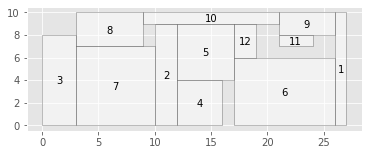

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
plt.style.use('ggplot')

fig = plt.figure()
axis = fig.gca()
p = PatchCollection([
    plt.Rectangle((m.x[r].value, m.y[r].value), m.length[r], m.height[r], edgecolor='black', facecolor='white', alpha=0.5)
    for r in m.rectangles
], match_original=True)
axis.add_collection(p)
for r in m.rectangles:
    axis.annotate(str(r), xy=(m.x[r].value + m.length[r] / 2, m.y[r].value + m.height[r] / 2), ha='center', va='center_baseline')
plt.axis('scaled')
plt.show()

In [8]:
!sudo apt update

Hit:1 http://us.archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://us.archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]   
Get:3 http://us.archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]0m
Get:4 http://us.archive.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]0m
Hit:5 http://ppa.launchpad.net/certbot/certbot/ubuntu bionic InRelease         
Get:6 http://us.archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [853 kB]
Get:7 http://us.archive.ubuntu.com/ubuntu bionic-updates/main Translation-en [298 kB]
Get:8 http://us.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [1,049 kB]
Get:9 http://us.archive.ubuntu.com/ubuntu bionic-updates/universe Translation-en [324 kB]
Get:10 http://us.archive.ubuntu.com/ubuntu bionic-security/main amd64 Packages [636 kB]m
Get:11 http://us.archive.ubuntu.com/ubuntu bionic-security/main Translation-en [208 kB]m
Get:12 http://us.archive.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [645 